In [13]:
import pandas as pd
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2

In [2]:
base_folder = "./real_experiment/calibration_dataset/"
frames_folder = "frames"
annotations_folder = "annotations"
frames_folders_path = os.path.join(base_folder, frames_folder)
dfs = []
for frames_name in tqdm(os.listdir(frames_folders_path)):
    ann_path = os.path.join(base_folder, annotations_folder, f"{frames_name}.txt").replace("frames", "points")
    frames_path = os.path.join(frames_folders_path, frames_name)
    p = Path(frames_path).glob('*.png')
    paths = [str(path.absolute()) for path in p]
    df_files = pd.DataFrame({"paths": paths})
    df_files["ind"] = df_files.paths.apply(lambda x: Path(x).stem)
    df = pd.read_csv(
        ann_path,
        sep = " ",
        header=None
    )
    cols = [
        "timestamp", "x_gt", "y_gt", "x1", "y1",
        "x2", "y2", "screen_w", "screen_h"
    ]
    df.columns = cols
    
    df["x_normalized"] = df["x_gt"] / df["screen_w"]
    df["y_normalized"] = df["y_gt"] / df["screen_h"]
    df["timestamp"] = df["timestamp"].apply(str)
    full_df = df_files.merge(df, left_on="ind", right_on="timestamp").drop(columns = ["ind"])
    dfs.append(full_df)

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 107.46it/s]


In [3]:
full_df = pd.concat(dfs)

In [4]:
full_df["participant_name"] = full_df["paths"].apply(lambda x: x.split("/")[-2].split("_")[2])

In [5]:
full_df_train = full_df[full_df["participant_name"] != "marina"]

In [6]:
full_df_train["participant_name"].value_counts()

participant_name
misha      227
nikita     177
vitalya    126
nastya     100
lilya       92
Name: count, dtype: int64

In [7]:
df_p = full_df_train[full_df_train["participant_name"] == "vitalya"]

In [8]:
df_p.shape

(126, 13)

In [9]:
from sklearn.cluster import AgglomerativeClustering

coords = df_p[["x_normalized",	"y_normalized"]].values
aggl = AgglomerativeClustering(
    n_clusters=None,
    metric="euclidean",
    distance_threshold=0.05
)
aggl.fit(coords)

AgglomerativeClustering(distance_threshold=0.05, metric='euclidean',
                        n_clusters=None)

In [10]:
from itertools import cycle, islice
colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                            "#357eb8",
                            "#ff9f00",
                            "#4daf5a",
                            "#f741bf",
                            "#a65328",
                            "#914ea3",
                            "#919999",
                            "#e71a1c",
                            "#dede10"
                        ]
                    ),
                    len(np.unique(aggl.labels_)),
                )
            )
        )

In [11]:
len(colors)

55

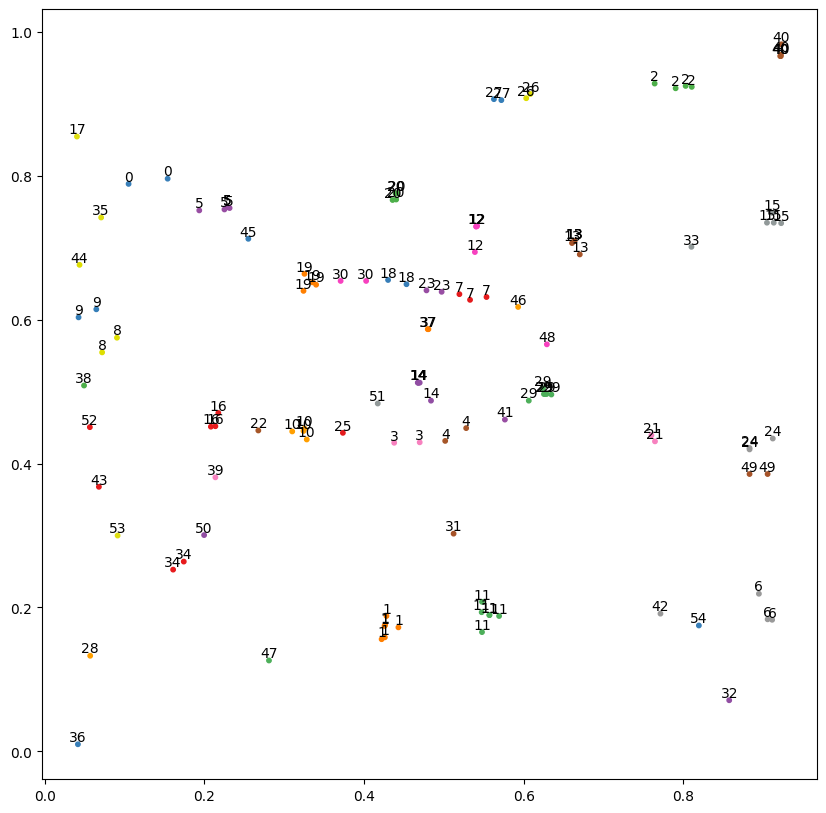

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(coords[:, 0], coords[:, 1], s=10, color=colors[aggl.labels_])
for i, j, l in zip(coords[:, 0],coords[:, 1], aggl.labels_):
    plt.text(i,j, l, ha='center', va='bottom')
plt.show()

In [27]:
df_p["cluster"] = aggl.labels_

/tmp/ipykernel_86405/501989376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p["cluster"] = aggl.labels_


In [107]:
def select_frame(input_):
    imgs_cluster = []
    for path in input_.values:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128, 128))
        img = (img - np.mean(img)) / img.std()
        imgs_cluster.append(img.flatten())
    imgs_cluster = np.vstack(imgs_cluster)
    norms = np.expand_dims(np.linalg.norm(imgs_cluster, axis = 1), axis=1)
    norms_matrix = norms @ norms.T
    sims = np.matmul(imgs_cluster, imgs_cluster.T) / norms_matrix
    sum_sim = np.sum(sims, axis = 0)
    best_img_ind = np.argmax(sum_sim)
    return input_.values[best_img_ind]

In [106]:
# for path in df_p[df_p["cluster"] == 29]["paths"].values:
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = cv2.resize(img, (128, 128))
#     plt.imshow(img, cmap="gray")
#     plt.show()

In [108]:
columns_first = ["paths", "timestamp", "screen_w", "screen_h", 'participant_name']
agg_dict = {column : "first" for column in columns_first}
agg_dict["paths"] = select_frame
for col in df_p.columns:
    if col not in columns_first + ["cluster"]:
        agg_dict[col] = "mean"
agg_dict

{'paths': <function __main__.select_frame(input_)>,
 'timestamp': 'first',
 'screen_w': 'first',
 'screen_h': 'first',
 'participant_name': 'first',
 'x_gt': 'mean',
 'y_gt': 'mean',
 'x1': 'mean',
 'y1': 'mean',
 'x2': 'mean',
 'y2': 'mean',
 'x_normalized': 'mean',
 'y_normalized': 'mean'}

In [109]:
df_cleaned_p = df_p.groupby("cluster").agg(agg_dict)
df_cleaned_p.head()

,paths,timestamp,screen_w,screen_h,participant_name,x_gt,y_gt,x1,y1,x2,y2,x_normalized,y_normalized
cluster,,,,,,,,,,,,,
0,/home/ubuntu/projects/tweakle/gaze_detection/r...,1697649747.321322,2474,1520,vitalya,320.500000,1204.500000,240.500000,1124.500000,400.500000,1284.500000,0.129547,0.792434
1,/home/ubuntu/projects/tweakle/gaze_detection/r...,1697649682.013433,2474,1520,vitalya,1060.166667,259.666667,980.166667,179.666667,1140.166667,339.666667,0.428523,0.170833
2,/home/ubuntu/projects/tweakle/gaze_detection/r...,1697649731.226912,2474,1520,vitalya,1959.000000,1405.500000,1879.000000,1325.500000,2039.000000,1485.500000,0.791835,0.924671
3,/home/ubuntu/projects/tweakle/gaze_detection/r...,1697649760.6136498,2474,1520,vitalya,1122.500000,652.500000,1042.500000,572.500000,1202.500000,732.500000,0.453719,0.429276
4,/home/ubuntu/projects/tweakle/gaze_detection/r...,1697649762.448297,2474,1520,vitalya,1273.500000,669.500000,1193.500000,589.500000,1353.500000,749.500000,0.514753,0.440461


In [110]:
new_dfs = []

columns_first = ["paths", "timestamp", "screen_w", "screen_h", 'participant_name']
agg_dict = {column : "first" for column in columns_first}
agg_dict["paths"] = select_frame
for col in df_p.columns:
    if col not in columns_first + ["cluster"]:
        agg_dict[col] = "mean"

for part in tqdm(full_df_train["participant_name"].unique()):
    df_p = full_df_train[full_df_train["participant_name"] == part]
    coords = df_p[["x_normalized",	"y_normalized"]].values
    aggl = AgglomerativeClustering(
        n_clusters=None,
        metric="euclidean",
        distance_threshold=0.05
    )
    aggl.fit(coords)
    df_p["cluster"] = aggl.labels_
    df_cleaned_p = df_p.groupby("cluster").agg(agg_dict)
    new_dfs.append(df_cleaned_p)

  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_86405/2161703093.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p["cluster"] = aggl.labels_
 20%|█████████                                    | 1/5 [00:06<00:27,  6.80s/it]/tmp/ipykernel_86405/2161703093.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p["cluster"] = aggl.labels_
 40%|██████████████████                           | 2/5 [00:13<00:19,  6.53s/it]/tmp/ipykernel_86405/2161703093.py:19: S

In [111]:
pd.concat(new_dfs).participant_name.value_counts()

participant_name
nikita     109
misha      102
nastya      79
lilya       72
vitalya     55
Name: count, dtype: int64

In [112]:
full_df_train.participant_name.value_counts()

participant_name
misha      227
nikita     177
vitalya    126
nastya     100
lilya       92
Name: count, dtype: int64

In [113]:
cleaned_train_df = pd.concat(new_dfs)

In [114]:
cleaned_train_df.to_csv("real_experiment/calibration_dataset/cleaned_train.csv", index = False)